# Non-Differentiable Shader

In this notebook a non-differentiable renderer that can render scenes described as .yaml files is presented.  
We provide a default shader with soft and hard shadows.   

In [1]:
from collections import namedtuple
from IPython.display import display

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import source.tensorize as t
from source.shader import *
from source.geometry import *

%load_ext autoreload
%autoreload 2

### Load a scene 

We will us the utility functions to do so. Have a look at the predefined scenes.

In [2]:
from source.scene import *
%ls ./scenes

cube.yaml                          small01.yaml  small05.yaml
gradient_test_1.ground_truth.yaml  small02.yaml  triangle_test.yaml
gradient_test_1.init1.yaml         small03.yaml
invalid_scene_01.yaml              small04.yaml


These are the objects the scene contains we chose

In [4]:
#load scene
scene = parse_scene('./scenes/small01.yaml')
#scene = parse_scene('./scenes/triangle_test.yaml')
#scene = parse_scene('./scenes/small05.yaml')

#scene = parse_scene('./scenes/invalid_scene_01.yaml')

print([key for key in scene])

['ball_1', 'ball_2', 'ball_3', 'floor', 'wall', 'light_1', 'light_2', 'camera']


Delete objects or steal objects from other scene if desired.

In [5]:
#del scene['light_2']
#print([key for key in scene])

#other_scene = parse_scene('./scenes/small01.yaml')
#scene['camera'] = other_scene['camera']
#scene['light_1'] = other_scene['light_1']

Now seperate the objects into different rendering classes

In [6]:
camera_name, camera = [ (key,scene[key]) for key in scene if type(scene[key]) is Camera ][0]
lights = { key : scene[key] for key in scene if type(scene[key]) is PointLight}
objects = { key : scene[key] for key in scene if type(scene[key]) in [Sphere, Plane, Triangle]}
    
print("Camera: '%s'" % camera_name)
print('Objects: ', [key for key in objects])
print('Lights: ', [key for key in lights])

Camera: 'camera'
Objects:  ['ball_1', 'ball_2', 'ball_3', 'floor', 'wall']
Lights:  ['light_1', 'light_2']


### Rendering

The render procedure can be described in pseudo code as follows:
1. camera shoots ray $\{s+t\cdot d | t>0 \} $
2. for every object and every light do:
    - check whether rays intersect with object, if not stop rendering. 
    - calculate intersection point $s'$
    - add ambient color to pixel 
    - shoot shadow ray $\{s' + t \cdot \ell | t > 0 \}$, where $\ell$ is the light direction
    - check if shadow ray intersects with another object
    - if other object is closer than the light source stop rendering
    - otherwise add color from Phong shader to pixel

The *if*-statements in our pseudo-code are expressed as binary masks in the implementation below.
Whether intersection occurs is expressed similarly and is visualized as stencil images. 

In [7]:
def render(camera, objects, lights):
    _t =  tensorize_scene_object
    
    #initial rays
    s,d = construct_initial_rays( _t(camera) )  #W,H,3
    s = s.reshape((-1,3)) #W*H,3
    d = d.reshape((-1,3))
    
    
    #clear screen buffers
    W,H = camera.width, camera.height 
    screen_depth = -t.ones((W,H))
    screen_color = t.zeros((W,H,3))
    
    #loop over object
    for objname in objects:
        obj = objects[objname]
        
        #calculate intersections
        if type(obj) is Sphere:
            dist, normal = intersect_rays_with_sphere( (s,d), _t(obj), return_normal=True )
        elif type(obj) is Plane:
            dist, normal = intersect_rays_with_plane( (s,d), _t(obj), return_normal=True )
        elif type(obj) is Triangle:
            dist, normal = intersect_rays_with_triangle( (s,d), _t(obj), return_normal=True )
        print('object ', objname, ' type ', type(obj))
        
        buffer = screen_depth.flatten()
        mask = (dist>0.) & ( (buffer >= dist) | (buffer <= 1e-3) )
        s_new = s + dist[:,None] * d
        t
        color = t.zeros((W*H,3))
        
        #loop over lights
        for lightname in lights:
            light = lights[lightname] 
            
            #light ray direction
            if type(light) is PointLight:
                light_dir = s_new - t.astensor( light.position[None, :] )
                light_dist = t.sqrt( t.sum(light_dir**2, axis=-1) + 1e-9)
                light_dir = -light_dir / light_dist[:,None]                
            
            #shadow ray
            shadow = t.zeros((W*H), dtype=t.bool)
            for castername in objects:
                    
                caster = objects[castername]
                    
                if type(caster) is Sphere:
                    caster_dist = intersect_rays_with_sphere( (s_new,light_dir), _t(caster) )
                elif type(caster) is Plane:
                    caster_dist = intersect_rays_with_plane( (s_new,light_dir), _t(caster) )
                elif type(caster) is Triangle:
                    caster_dist = intersect_rays_with_triangle( (s_new,light_dir), _t(caster) )
                
                covers = (light_dist > caster_dist) & (caster_dist > 1e-3)
                shadow = shadow | covers
                
            #run shader to get color 
            lighting = phong(d, normal, light_dir, 
                             shadow, t.astensor(obj.color), t.astensor(obj.shininess),
                             t.astensor(light.ambient), 
                             t.astensor(light.diffuse), 
                             t.astensor(light.specular)) 
            lighting = lighting
            color = color + lighting
            
        color = t.maximum(t.astensor(0.), t.minimum(t.astensor(1.), color))
        
        
        # update screen
        mask = mask.reshape((W,H))
        #plt.imshow(mask.cpu().numpy().transpose(), cmap='gray')
        #plt.show()
        
        dist = dist.reshape((W,H))
        color = color.reshape((W,H,3))
        screen_depth = t.where(mask, dist, screen_depth)
        screen_color = t.where(mask[:,:,None], color, screen_color)
        
       
    return screen_color.detach().cpu().numpy()   
    #return screen_color.detach().cpu().numpy()

object  ball_1  type  <class 'source.scene.Sphere'>
object  ball_2  type  <class 'source.scene.Sphere'>
object  ball_3  type  <class 'source.scene.Sphere'>
object  floor  type  <class 'source.scene.Plane'>
object  wall  type  <class 'source.scene.Plane'>


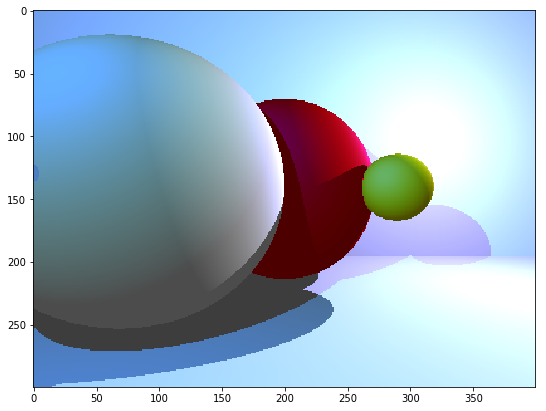

In [8]:
img = render(camera, objects, lights)
plt.figure(figsize=(9,7))

#plt.imshow(img.transpose(), cmap='gray', vmin=0., vmax=30.)
plt.imshow(img[:,::-1,:].transpose((1,0,2)))

plt.show()